In [1]:
import os
import andes
import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import scipy.stats as stat
import seaborn as sns

from andes.interop.pandapower import to_pandapower, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)
from math import ceil, floor

# virtual inertia scheduling class
from pdpower import make_link_table
from visopf import vis2_tds, loadnn

# function for main
from vistds import get_andes_case, get_load, disturbance

# TDS for VIS

## ini andes attribute

In [2]:
# ini andes attribute
case_path = '/VIS_opf/ieee39_vis_tds.xlsx'
ssa = get_andes_case(case_path)
ssa.TDS.config.no_tqdm = 1 # trun off tds progress fig to speed up sim

# ini load
ptotal = ssa.PQ.as_df()['p0'].sum()
gentotal = ssa.PV.as_df()['Sn'].sum() + ssa.Slack.as_df()['Sn'].sum()
gentotal /= ssa.config.mva
l_rate = ptotal/gentotal

print(f'Gen capacity is: {gentotal} p.u.\
        \nInitial load is: {ptotal.round(4)} p.u.\
        \ninitial load rate is {l_rate*100} %' )


Working directory: "/Users/buxinshe/Documents/git-repo/andes/bshe/VIS_opf"
> Loaded config from file "/Users/buxinshe/.andes/andes.rc"
> Loaded generated Python code in "/Users/buxinshe/.andes/pycode".
Parsing input file "/Users/buxinshe/Documents/git-repo/andes/bshe/VIS_opf/ieee39_vis_tds.xlsx"...
Input file parsed in 0.0910 seconds.
ACEc <1> added BusFreq <BusFreq_21> linked to bus <1>
System internal structure set up in 0.0223 seconds.


Gen capacity is: 109.389 p.u.        
Initial load is: 58.564 p.u.        
initial load rate is 53.537375787327804 %


array([0.04160092, 0.01264898, 0.02950006, 0.0357116 , 0.04872493,
       0.05094144, 0.03748916, 0.03005168, 0.05757978, 0.07010216,
       0.04790113, 0.04426615])

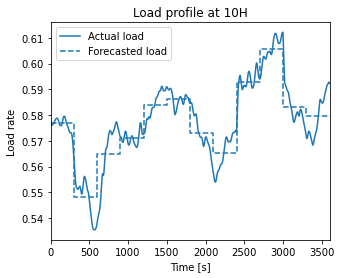

In [3]:
# load profile
data_path = '/VIS_opf/dsyn.csv'
d_syn, load_pic, dpe = get_load(data_path, load_time=10, l_rate=l_rate, scale=1.4)
dpe

# ini visopf instance

In [4]:
# get neural network data
nn_path = '/VIS_opf/NN_train'
nn, norm = loadnn(nn_path)

# ini visopf attribute
ssvis = vis2_tds(norm=norm, nn=nn, dpe=0.05, rocof_lim=0.0069, nadir_lim=0.01)

# set vsg gen
vsg_ieee39 = ['PV_1', 'PV_6', 'PV_8', 'PV_9']

# load from andes
ssvis.from_andes(ssa, vsg_ieee39, Sbase=1000)

# add gen cost:
# Note: if two gens have the same cost, optimization results of
#       pandapower and gurobipy may be different.
linearcost = [
                1,   # PV_1 vsg
                20, 
                20,
                20, 
                20, 
                1,   # PV_6 vsg
                20, 
                1,   # PV_8 vsg
                1,   # PV_9 vsg 
                20   # slack
            ]
quadraticcost = [
                0.001,   # PV_1 vsg
                0.014,
                0.020,
                0.019,
                0.021,
                0.001,   # PV_6 vsg
                0.020,
                0.001,   # PV_8 vsg
                0.001,   # PV_9 vsg
                0.026    # slack
            ]

# set up cost
ssvis.cost['c1'] = linearcost
ssvis.cost['c2'] = quadraticcost
ssvis.update_dict()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-13


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0033 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916162515
2: |F(x)| = 0.1315330771
3: |F(x)| = 0.0003398595952
4: |F(x)| = 4.189813829e-09
Converged in 5 iterations in 0.0048 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
Note: Control (dynamic) parameters are renormalized based on case Sbase rather then to andes base


# ini pandapower instance

In [5]:
# convert andes to a pandapower instance
ssp = to_pandapower(ssa)

# set up pandapower gen cost
gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1
gen_cost[:, 4] = quadraticcost  # c2

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0034 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916162515
2: |F(x)| = 0.1315330771
3: |F(x)| = 0.0003398595952
4: |F(x)| = 4.189813829e-09
Converged in 5 iterations in 0.0042 seconds.
Power flow results are consistent. Conversion is successful.


True

### make link table between pandapower and andes

In [6]:
# --- link pandapower output to andes key ---
ssa_key = make_link_table(ssa)

# make index table to change pandapower and andes setting point
# pandapwoer uses dataframe index, i.g. 0, 1, 2 ....
# andes uses idx to call variable

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})

ssa_key2 = pd.merge(
                        left=ssa_key,
                        right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                        on='stg_idx', 
                        how='left'
                    )

# --- device idx ---
# use to set andes setting point
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()   
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist() 
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist() # static gen
ssa_rg_idx = ssa_key2.rg_idx.dropna().tolist()   # renewable gen: vsg

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)

ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

## TDS parameters

In [7]:
# --- TDS Constants ---
t_total = 3600  # total simulation time

# update interval
intv_ed = 300   # RTED
intv_agc = 4    # AGC
intv_pq = 1     # PQ load
intv_step = 100 # step change to smooth the setpoitns

# number of intervals
n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- TDS vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.2 # 0.05
Ki = 0.1
ace_res = pd.DataFrame()

# initial load value
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

In [8]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = 1 * ssp.gen.max_p_mw # for AC

# store original generator data
ssp_gen0 = ssp.gen.copy()

# store visopf output
vis_res = {}

for time in range(t_total):  # t_total

    # ----------------------- RTED (VIS opf) interval -------------------------
    if time % intv_ed == 0:
        """
            RTED update with vis opf

            attributes:
            ----------
            - 01 get disturbance
            - 02 update visopf instance
            - 03 update pandapower instance
            - 04 update andes instance
        """
        # --- 01 get disturbance ---
        idx_ed = time // intv_ed
        load, dpe, dvsg_capacity = disturbance(d_syn, idx_ed, intv_ed)

        # --- 02 update visopf instance ---
        # load
        ssvis.load['p0'] = ssa_p0 * load # visopf load update
        # dpe
        ssvis.dpe = dpe
        # vsg gen capacity
        # TODO ... update vsg gen capacity of visopf

        ssvis.update_dict()

        # solve visopf
        sgres, vsg_res, sys_MD = ssvis.get_res()
        # save visopf result
        vis_res[f'sg_{idx_ed}'] = sgres.copy()
        vis_res[f'vsg_{idx_ed}'] = vsg_res.copy()
        vis_res[f'MDsys_{idx_ed}'] = sys_MD.copy()
        vis_res[f'dpe_{idx_ed}'] = dpe
        vis_res[f'cost_{idx_ed}'] = ssvis.mdl.getObjective().getValue()

        # --- 03 update pandapwoer instance ---
        # load
        ssp.load.scaling = load
        # pandapower gen
        ssp_gen = pd.merge(
                            left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=sgres.rename(columns={'gen': 'stg_idx'}),
                            on='stg_idx',
                            how='left'
                        )

        # vsg power reserve limits
        # TODO: integrate delta vsg capacity change here
        ssp_gen['vsg_up'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['vsg_d'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva

        ssp.gen.max_p_mw = ssp_gen['vsg_up']
        ssp.gen.min_p_mw = ssp_gen['vsg_d']

        # run pandapower ACOPF, modify setpoints
        # store setpoints
        if time > 0:
            p0 = ssp_res['p'].values        # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # solve ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True) # Fill NA wil False

        # reset Generator limtis to normal limits
        # TODO: integrate delta vsg capacity change here
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

        # --- 04 update andes instance ---
        ssa.REGCV1.set(
                        src='M', 
                        idx= ssa.REGCV1.idx.v,
                        attr='v',
                        value= vsg_res['Mvsg']
                    )
        ssa.REGCV1.set(
                        src='D', 
                        idx= ssa.REGCV1.idx.v, 
                        attr='v',
                        value= vsg_res['Dvsg']
                    )

    # ---------------------- AGC interval -------------------------
    """
        AGC update

        attributes:
        ----------
        - 01 assign ACE signla to gen 
        - 02 smooth setpoints
    """
    ace_gain = 1

    if time % intv_agc == 0:
        idx_agc = time // intv_agc - idx_ed * n_agc
        # --- 01 allocate AGC ---

        # ACE_raw > 0: assign to expensive gen
        # ACE_raw < 0: assign to cheap gen
        # Note: allocate to synchronous generator governors
        # if ACE_raw > 0:
        #     agc_idx = ['TGOV1_10', 'TGOV1_2'] # TODO: change to expensive gen
        # else:
        #     agc_idx = ['TGOV1_4', 'TGOV1_5'] # TODO: change to cheap gen

        agc_idx = ['TGOV1_2','TGOV1_3','TGOV1_4','TGOV1_5','TGOV1_7', 'TGOV1_10']

        ssa.TurbineGov.set(
                            src='paux0',
                            idx= agc_idx,
                            attr='v',
                            value= ACE_raw/len(agc_idx) # allocate equally to each agc gen
                        )

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            idx_step = min((time - idx_ed * intv_ed) // intv_agc + 1, n_step)

            ssp_res['pref_step'] = ssp_res.p - ssp_res.p0
            # smooth change threshold: 0.1
            # check ssp_res format for vsg setpoints
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.01].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.p0 + ssp_res.pref_delta

            # update SynGen setpoints
            cond_gov = ssp_res.controllable & ssp_res.gov_idx.astype(bool)
            ssa.TurbineGov.set(
                                src='pref0', 
                                idx=ssp_res.gov_idx[cond_gov].tolist(),
                                attr='v',
                                value=ssp_res.pref[cond_gov].values
                            )

            # update DG setpoints
            cond_dg = ssp_res.controllable & ssp_res.dg_idx.astype(bool)
            ssa.DG.set(
                        src='pref0', 
                        idx=ssp_res.dg_idx[cond_dg].tolist(),
                        attr='v', 
                        value=ssp_res.pref[cond_dg].values
                    )
                    
            # update vsg setpoints
            cond_rg = ssp_res.controllable & ssp_res.rg_idx.astype(bool)
            ssa.RenGen.set(
                                src='Pref', 
                                idx=ssp_res.rg_idx[cond_rg].tolist(),
                                attr='v',
                                value=ssp_res.pref[cond_rg].values
                            )

    # ----------------------- load change interval ----------------------
    """
        load change 

        attributes:
        ----------
        - 01 update load
        - 02 run TDS
    """
    # Initially, alter StaticGen: p0 and q0, RUN power flow
    # Otherwise, alter Ppf and Qpf
    if time == 0:
        # get idx from pandapower results
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        stg_opf_v = ssp_res.vm_pu[ssp_res.controllable].tolist()

        ssa.StaticGen.set(
                            src='p0',
                            idx=stg_opf_idx,
                            attr='v',
                            value=stg_opf_val
                        )
        ssa.StaticGen.set(
                            src='v0', 
                            idx=stg_opf_idx, 
                            attr='v', 
                            value=stg_opf_v
                        )

        # initial load point set as the dispatch point
        ssa.PQ.set(
                    src='p0', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_p0 * load
                )
        ssa.PQ.set(
                    src='q0', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_q0 * load
                )
        ssa.PFlow.run()
    else:
        ssa.PQ.set(
                    src='Ppf', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_p0 * d_syn['sload'].iloc[time]
                )
        ssa.PQ.set(
                    src='Qpf', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_q0 * d_syn['sload'].iloc[time]
                )

    # ----------------------- run TDS, cal ACE ----------------------
    # run TDS
    ssa.TDS.config.tf = time
    if time == 0:
        ssa.TDS.init()
        ACE_raw = 0 # delete when run TDS
    ssa.TDS.run()

    # update AGC using PI Controller
    ACE_integral += ssa.ACEc.ace.v.sum()
    ACE_raw = -( Kp * ssa.ACEc.ace.v.sum() + Ki * ACE_integral )

   # ----------------------- TDS error break ----------------------
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {time} s.")

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11118 nonzeros
Model fingerprint: 0xe4e81412
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [4e-06, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Found heuristic solution: objective 619.8639265
Presolve removed 777 rows and 486 columns
Presolve time: 0.01s
Presolved: 263 rows, 192 columns, 2971 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 105 continuous, 87 integer (87 binary)

Root relaxation: objective 6.169187e+02, 281 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 616.919
RoCof prediction: 0 ; RoCof limit: 0.0069
Nadir prediction: -0 ; Nadir limit 0.01


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0032 seconds.
0: |F(x)| = 8.068030505
1: |F(x)| = 3.62957008
2: |F(x)| = 0.2091936149
3: |F(x)| = 0.001290913006
4: |F(x)| = 4.882864202e-08
Converged in 5 iterations in 0.0043 seconds.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU_7  | 0.031  | 0.002
 GENROU_10 | 0.003  | 0.000


Initialization for dynamics completed in 0.0329 seconds.
Initialization was successful.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Simulation to t=0.00 sec completed 

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0xd6b90c6f
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e-07, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [6e-03, 2e+03]
Found heuristic solution: objective 585.3608735
Presolve removed 739 rows and 438 columns
Presolve time: 0.01s
Presolved: 301 rows, 240 columns, 3800 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 169 continuous, 71 integer (71 binary)

Root relaxation: objective 5.551708e+02, 382 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 555.171
RoCof prediction: -0.0069 ; RoCof limit: 0.0069
Nadir prediction: 0.00160519 ; Nadir limit 0.01


Simulation to t=300.00 sec completed in 0.0451 seconds.
Simulation to t=301.00 sec completed in 0.0416 seconds.
Simulation to t=302.00 sec completed in 0.0437 seconds.
Simulation to t=303.00 sec completed in 0.0414 seconds.
Simulation to t=304.00 sec completed in 0.0458 seconds.
Simulation to t=305.00 sec completed in 0.0396 seconds.
Simulation to t=306.00 sec completed in 0.0388 seconds.
Simulation to t=307.00 sec completed in 0.0363 seconds.
Simulation to t=308.00 sec completed in 0.0445 seconds.
Simulation to t=309.00 sec completed in 0.0386 seconds.
Simulation to t=310.00 sec completed in 0.0407 seconds.
Simulation to t=311.00 sec completed in 0.0370 seconds.
Simulation to t=312.00 sec completed in 0.0498 seconds.
Simulation to t=313.00 sec completed in 0.0409 seconds.
Simulation to t=314.00 sec completed in 0.0738 seconds.
Simulation to t=315.00 sec completed in 0.0396 seconds.
Simulation to t=316.00 sec completed in 0.0471 seconds.
Simulation to t=317.00 sec completed in 0.0398 s

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x5098cff8
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [7e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e-03, 2e+03]
Found heuristic solution: objective 846.3190236
Presolve removed 699 rows and 416 columns
Presolve time: 0.01s
Presolved: 341 rows, 262 columns, 4286 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 174 continuous, 88 integer (88 binary)

Root relaxation: objective 5.930314e+02, 709 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 593.252
RoCof prediction: 0.00526142 ; RoCof limit: 0.0069
Nadir prediction: -0.00086368 ; Nadir limit 0.01


Simulation to t=600.00 sec completed in 0.0400 seconds.
Simulation to t=601.00 sec completed in 0.0380 seconds.
Simulation to t=602.00 sec completed in 0.0395 seconds.
Simulation to t=603.00 sec completed in 0.0338 seconds.
Simulation to t=604.00 sec completed in 0.0409 seconds.
Simulation to t=605.00 sec completed in 0.0578 seconds.
Simulation to t=606.00 sec completed in 0.0363 seconds.
Simulation to t=607.00 sec completed in 0.0520 seconds.
Simulation to t=608.00 sec completed in 0.0377 seconds.
Simulation to t=609.00 sec completed in 0.0349 seconds.
Simulation to t=610.00 sec completed in 0.0388 seconds.
Simulation to t=611.00 sec completed in 0.0415 seconds.
Simulation to t=612.00 sec completed in 0.0360 seconds.
Simulation to t=613.00 sec completed in 0.0360 seconds.
Simulation to t=614.00 sec completed in 0.0411 seconds.
Simulation to t=615.00 sec completed in 0.0431 seconds.
Simulation to t=616.00 sec completed in 0.0368 seconds.
Simulation to t=617.00 sec completed in 0.0327 s

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0xca172b61
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [2e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [3e-03, 2e+03]
Presolve removed 701 rows and 418 columns
Presolve time: 0.02s
Presolved: 339 rows, 260 columns, 4267 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 173 continuous, 87 integer (87 binary)

Root relaxation: objective 6.062796e+02, 718 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 606.353
RoCof prediction: 0.00193943 ; RoCof limit: 0.0069
Nadir prediction: -0.000356164 ; Nadir limit 0.01


Simulation to t=900.00 sec completed in 0.0336 seconds.
Simulation to t=901.00 sec completed in 0.0365 seconds.
Simulation to t=902.00 sec completed in 0.0353 seconds.
Simulation to t=903.00 sec completed in 0.0326 seconds.
Simulation to t=904.00 sec completed in 0.0342 seconds.
Simulation to t=905.00 sec completed in 0.0347 seconds.
Simulation to t=906.00 sec completed in 0.0342 seconds.
Simulation to t=907.00 sec completed in 0.0328 seconds.
Simulation to t=908.00 sec completed in 0.0372 seconds.
Simulation to t=909.00 sec completed in 0.0355 seconds.
Simulation to t=910.00 sec completed in 0.0333 seconds.
Simulation to t=911.00 sec completed in 0.0328 seconds.
Simulation to t=912.00 sec completed in 0.0335 seconds.
Simulation to t=913.00 sec completed in 0.0331 seconds.
Simulation to t=914.00 sec completed in 0.0335 seconds.
Simulation to t=915.00 sec completed in 0.0348 seconds.
Simulation to t=916.00 sec completed in 0.0325 seconds.
Simulation to t=917.00 sec completed in 0.0351 s

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x8fb4383f
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [5e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Found heuristic solution: objective 848.4487353
Presolve removed 709 rows and 425 columns
Presolve time: 0.01s
Presolved: 331 rows, 253 columns, 4178 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 170 continuous, 83 integer (83 binary)

Root relaxation: objective 6.352682e+02, 696 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 635.421
RoCof prediction: 0.00406316 ; RoCof limit: 0.0069
Nadir prediction: -0.000733093 ; Nadir limit 0.01


Simulation to t=1200.00 sec completed in 0.0340 seconds.
Simulation to t=1201.00 sec completed in 0.0388 seconds.
Simulation to t=1202.00 sec completed in 0.0356 seconds.
Simulation to t=1203.00 sec completed in 0.0328 seconds.
Simulation to t=1204.00 sec completed in 0.0334 seconds.
Simulation to t=1205.00 sec completed in 0.0329 seconds.
Simulation to t=1206.00 sec completed in 0.0350 seconds.
Simulation to t=1207.00 sec completed in 0.0329 seconds.
Simulation to t=1208.00 sec completed in 0.0334 seconds.
Simulation to t=1209.00 sec completed in 0.0338 seconds.
Simulation to t=1210.00 sec completed in 0.0331 seconds.
Simulation to t=1211.00 sec completed in 0.0326 seconds.
Simulation to t=1212.00 sec completed in 0.0359 seconds.
Simulation to t=1213.00 sec completed in 0.0333 seconds.
Simulation to t=1214.00 sec completed in 0.0345 seconds.
Simulation to t=1215.00 sec completed in 0.0340 seconds.
Simulation to t=1216.00 sec completed in 0.0333 seconds.
Simulation to t=1217.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x9f703518
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [9e-09, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e-03, 2e+03]
Presolve removed 709 rows and 425 columns
Presolve time: 0.01s
Presolved: 331 rows, 253 columns, 4168 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 170 continuous, 83 integer (83 binary)

Root relaxation: objective 6.397141e+02, 681 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 639.74
RoCof prediction: 0.000692062 ; RoCof limit: 0.0069
Nadir prediction: -0.000124552 ; Nadir limit 0.01


Simulation to t=1500.00 sec completed in 0.0332 seconds.
Simulation to t=1501.00 sec completed in 0.0378 seconds.
Simulation to t=1502.00 sec completed in 0.0335 seconds.
Simulation to t=1503.00 sec completed in 0.0328 seconds.
Simulation to t=1504.00 sec completed in 0.0332 seconds.
Simulation to t=1505.00 sec completed in 0.0340 seconds.
Simulation to t=1506.00 sec completed in 0.0347 seconds.
Simulation to t=1507.00 sec completed in 0.0332 seconds.
Simulation to t=1508.00 sec completed in 0.0335 seconds.
Simulation to t=1509.00 sec completed in 0.0332 seconds.
Simulation to t=1510.00 sec completed in 0.0347 seconds.
Simulation to t=1511.00 sec completed in 0.0329 seconds.
Simulation to t=1512.00 sec completed in 0.0345 seconds.
Simulation to t=1513.00 sec completed in 0.0384 seconds.
Simulation to t=1514.00 sec completed in 0.0333 seconds.
Simulation to t=1515.00 sec completed in 0.0327 seconds.
Simulation to t=1516.00 sec completed in 0.0329 seconds.
Simulation to t=1517.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x393e2c5d
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [5e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Found heuristic solution: objective 630.0684771
Presolve removed 701 rows and 418 columns
Presolve time: 0.01s
Presolved: 339 rows, 260 columns, 4271 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 173 continuous, 87 integer (87 binary)

Root relaxation: objective 6.099402e+02, 409 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 609.94
RoCof prediction: -0.00401426 ; RoCof limit: 0.0069
Nadir prediction: 0.000765527 ; Nadir limit 0.01


Simulation to t=1800.00 sec completed in 0.0365 seconds.
Simulation to t=1801.00 sec completed in 0.0389 seconds.
Simulation to t=1802.00 sec completed in 0.1279 seconds.
Simulation to t=1803.00 sec completed in 0.0478 seconds.
Simulation to t=1804.00 sec completed in 0.0359 seconds.
Simulation to t=1805.00 sec completed in 0.0381 seconds.
Simulation to t=1806.00 sec completed in 0.0349 seconds.
Simulation to t=1807.00 sec completed in 0.0357 seconds.
Simulation to t=1808.00 sec completed in 0.0326 seconds.
Simulation to t=1809.00 sec completed in 0.0387 seconds.
Simulation to t=1810.00 sec completed in 0.0353 seconds.
Simulation to t=1811.00 sec completed in 0.0324 seconds.
Simulation to t=1812.00 sec completed in 0.0357 seconds.
Simulation to t=1813.00 sec completed in 0.0325 seconds.
Simulation to t=1814.00 sec completed in 0.0380 seconds.
Simulation to t=1815.00 sec completed in 0.0331 seconds.
Simulation to t=1816.00 sec completed in 0.0336 seconds.
Simulation to t=1817.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x8440f560
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [3e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-03, 2e+03]
Found heuristic solution: objective 597.4573778
Presolve removed 699 rows and 416 columns
Presolve time: 0.01s
Presolved: 341 rows, 262 columns, 4290 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 174 continuous, 88 integer (88 binary)

Root relaxation: objective 5.935367e+02, 406 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 593.537
RoCof prediction: -0.0022194 ; RoCof limit: 0.0069
Nadir prediction: 0.000427272 ; Nadir limit 0.01


Simulation to t=2100.00 sec completed in 0.0501 seconds.
Simulation to t=2101.00 sec completed in 0.0666 seconds.
Simulation to t=2102.00 sec completed in 0.0449 seconds.
Simulation to t=2103.00 sec completed in 0.0613 seconds.
Simulation to t=2104.00 sec completed in 0.0411 seconds.
Simulation to t=2105.00 sec completed in 0.0413 seconds.
Simulation to t=2106.00 sec completed in 0.0395 seconds.
Simulation to t=2107.00 sec completed in 0.0408 seconds.
Simulation to t=2108.00 sec completed in 0.0718 seconds.
Simulation to t=2109.00 sec completed in 0.0612 seconds.
Simulation to t=2110.00 sec completed in 0.0396 seconds.
Simulation to t=2111.00 sec completed in 0.0423 seconds.
Simulation to t=2112.00 sec completed in 0.0400 seconds.
Simulation to t=2113.00 sec completed in 0.0391 seconds.
Simulation to t=2114.00 sec completed in 0.0423 seconds.
Simulation to t=2115.00 sec completed in 0.1165 seconds.
Simulation to t=2116.00 sec completed in 0.0403 seconds.
Simulation to t=2117.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x98705bb0
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e-07, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [6e-03, 2e+03]
Presolve removed 733 rows and 436 columns
Presolve time: 0.02s
Presolved: 307 rows, 242 columns, 3867 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 167 continuous, 75 integer (75 binary)

Root relaxation: objective 6.565710e+02, 682 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 656.8
RoCof prediction: 0.0069 ; RoCof limit: 0.0069
Nadir prediction: -0.00149108 ; Nadir limit 0.01


Simulation to t=2400.00 sec completed in 0.0572 seconds.
Simulation to t=2401.00 sec completed in 0.0605 seconds.
Simulation to t=2402.00 sec completed in 0.0710 seconds.
Simulation to t=2403.00 sec completed in 0.0861 seconds.
Simulation to t=2404.00 sec completed in 0.0579 seconds.
Simulation to t=2405.00 sec completed in 0.0512 seconds.
Simulation to t=2406.00 sec completed in 0.0464 seconds.
Simulation to t=2407.00 sec completed in 0.0488 seconds.
Simulation to t=2408.00 sec completed in 0.0575 seconds.
Simulation to t=2409.00 sec completed in 0.0521 seconds.
Simulation to t=2410.00 sec completed in 0.0493 seconds.
Simulation to t=2411.00 sec completed in 0.0584 seconds.
Simulation to t=2412.00 sec completed in 0.0913 seconds.
Simulation to t=2413.00 sec completed in 0.0405 seconds.
Simulation to t=2414.00 sec completed in 0.0381 seconds.
Simulation to t=2415.00 sec completed in 0.0368 seconds.
Simulation to t=2416.00 sec completed in 0.0400 seconds.
Simulation to t=2417.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x20041cd7
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [5e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Found heuristic solution: objective 850.8272239
Presolve removed 709 rows and 425 columns
Presolve time: 0.02s
Presolved: 331 rows, 253 columns, 4178 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 170 continuous, 83 integer (83 binary)

Root relaxation: objective 6.824355e+02, 699 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 682.583
RoCof prediction: 0.00390987 ; RoCof limit: 0.0069
Nadir prediction: -0.000685688 ; Nadir limit 0.01


Simulation to t=2700.00 sec completed in 0.0396 seconds.
Simulation to t=2701.00 sec completed in 0.0507 seconds.
Simulation to t=2702.00 sec completed in 0.0401 seconds.
Simulation to t=2703.00 sec completed in 0.0401 seconds.
Simulation to t=2704.00 sec completed in 0.0409 seconds.
Simulation to t=2705.00 sec completed in 0.0472 seconds.
Simulation to t=2706.00 sec completed in 0.0396 seconds.
Simulation to t=2707.00 sec completed in 0.0390 seconds.
Simulation to t=2708.00 sec completed in 0.0394 seconds.
Simulation to t=2709.00 sec completed in 0.0400 seconds.
Simulation to t=2710.00 sec completed in 0.0527 seconds.
Simulation to t=2711.00 sec completed in 0.0410 seconds.
Simulation to t=2712.00 sec completed in 0.0553 seconds.
Simulation to t=2713.00 sec completed in 0.0488 seconds.
Simulation to t=2714.00 sec completed in 0.0499 seconds.
Simulation to t=2715.00 sec completed in 0.0429 seconds.
Simulation to t=2716.00 sec completed in 0.0449 seconds.
Simulation to t=2717.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x026f0d38
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [9e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Presolve removed 706 rows and 423 columns
Presolve time: 0.02s
Presolved: 334 rows, 255 columns, 4207 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 171 continuous, 84 integer (84 binary)

Root relaxation: objective 6.329128e+02, 405 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 632.913
RoCof prediction: -0.00662495 ; RoCof limit: 0.0069
Nadir prediction: 0.00124638 ; Nadir limit 0.01


Simulation to t=3000.00 sec completed in 0.0704 seconds.
Simulation to t=3001.00 sec completed in 0.1036 seconds.
Simulation to t=3002.00 sec completed in 0.1408 seconds.
Simulation to t=3003.00 sec completed in 0.1088 seconds.
Simulation to t=3004.00 sec completed in 0.0695 seconds.
Simulation to t=3005.00 sec completed in 0.0725 seconds.
Simulation to t=3006.00 sec completed in 0.0846 seconds.
Simulation to t=3007.00 sec completed in 0.0795 seconds.
Simulation to t=3008.00 sec completed in 0.0978 seconds.
Simulation to t=3009.00 sec completed in 0.0591 seconds.
Simulation to t=3010.00 sec completed in 0.0859 seconds.
Simulation to t=3011.00 sec completed in 0.0907 seconds.
Simulation to t=3012.00 sec completed in 0.0780 seconds.
Simulation to t=3013.00 sec completed in 0.1698 seconds.
Simulation to t=3014.00 sec completed in 0.1276 seconds.
Simulation to t=3015.00 sec completed in 0.1025 seconds.
Simulation to t=3016.00 sec completed in 0.0605 seconds.
Simulation to t=3017.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x174bc92d
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 4e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [2e-03, 2e+03]
Presolve removed 703 rows and 420 columns
Presolve time: 0.02s
Presolved: 337 rows, 258 columns, 4245 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 172 continuous, 86 integer (86 binary)

Root relaxation: objective 6.248915e+02, 415 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS
Simulation to t=3300.00 sec completed in 0.0489 seconds.
Simulation to t=3301.00 sec completed in 0.1141 seconds.
Simulation to t=3302.00 sec completed in 0.1175 seconds.
Simulation to t=3303.00 sec completed in 0.1089 seconds.
Simulation to t=3304.00 sec completed in 0.0532 seconds.
Simulation to t=3305.00 sec completed in 0.0788 seconds.
Simulation to t=3306.00 sec completed in 0.0545 seconds.
Simulation to t=3307.00 sec completed in 0.0491 seconds.
Simulation to t=3308.00 sec completed in 0.0672 seconds.
Simulation to t=3309.00 sec completed in 0.2075 seconds.
Simulation to t=3310.00 sec completed in 0.0919 seconds.
Simulation to t=3311.00 sec completed in 0.1395 seconds.
Simulation to t=3312.00 sec completed in 0.0668 seconds.
Simulation to t=3313.00 sec completed in 0.0804 seconds.
Simulation to t=3314.00 sec completed in 0.0622 seconds.
Simulation to t=3315.00 sec completed in 0.8810 seconds.
Simula

# Plot results

## plot load profile

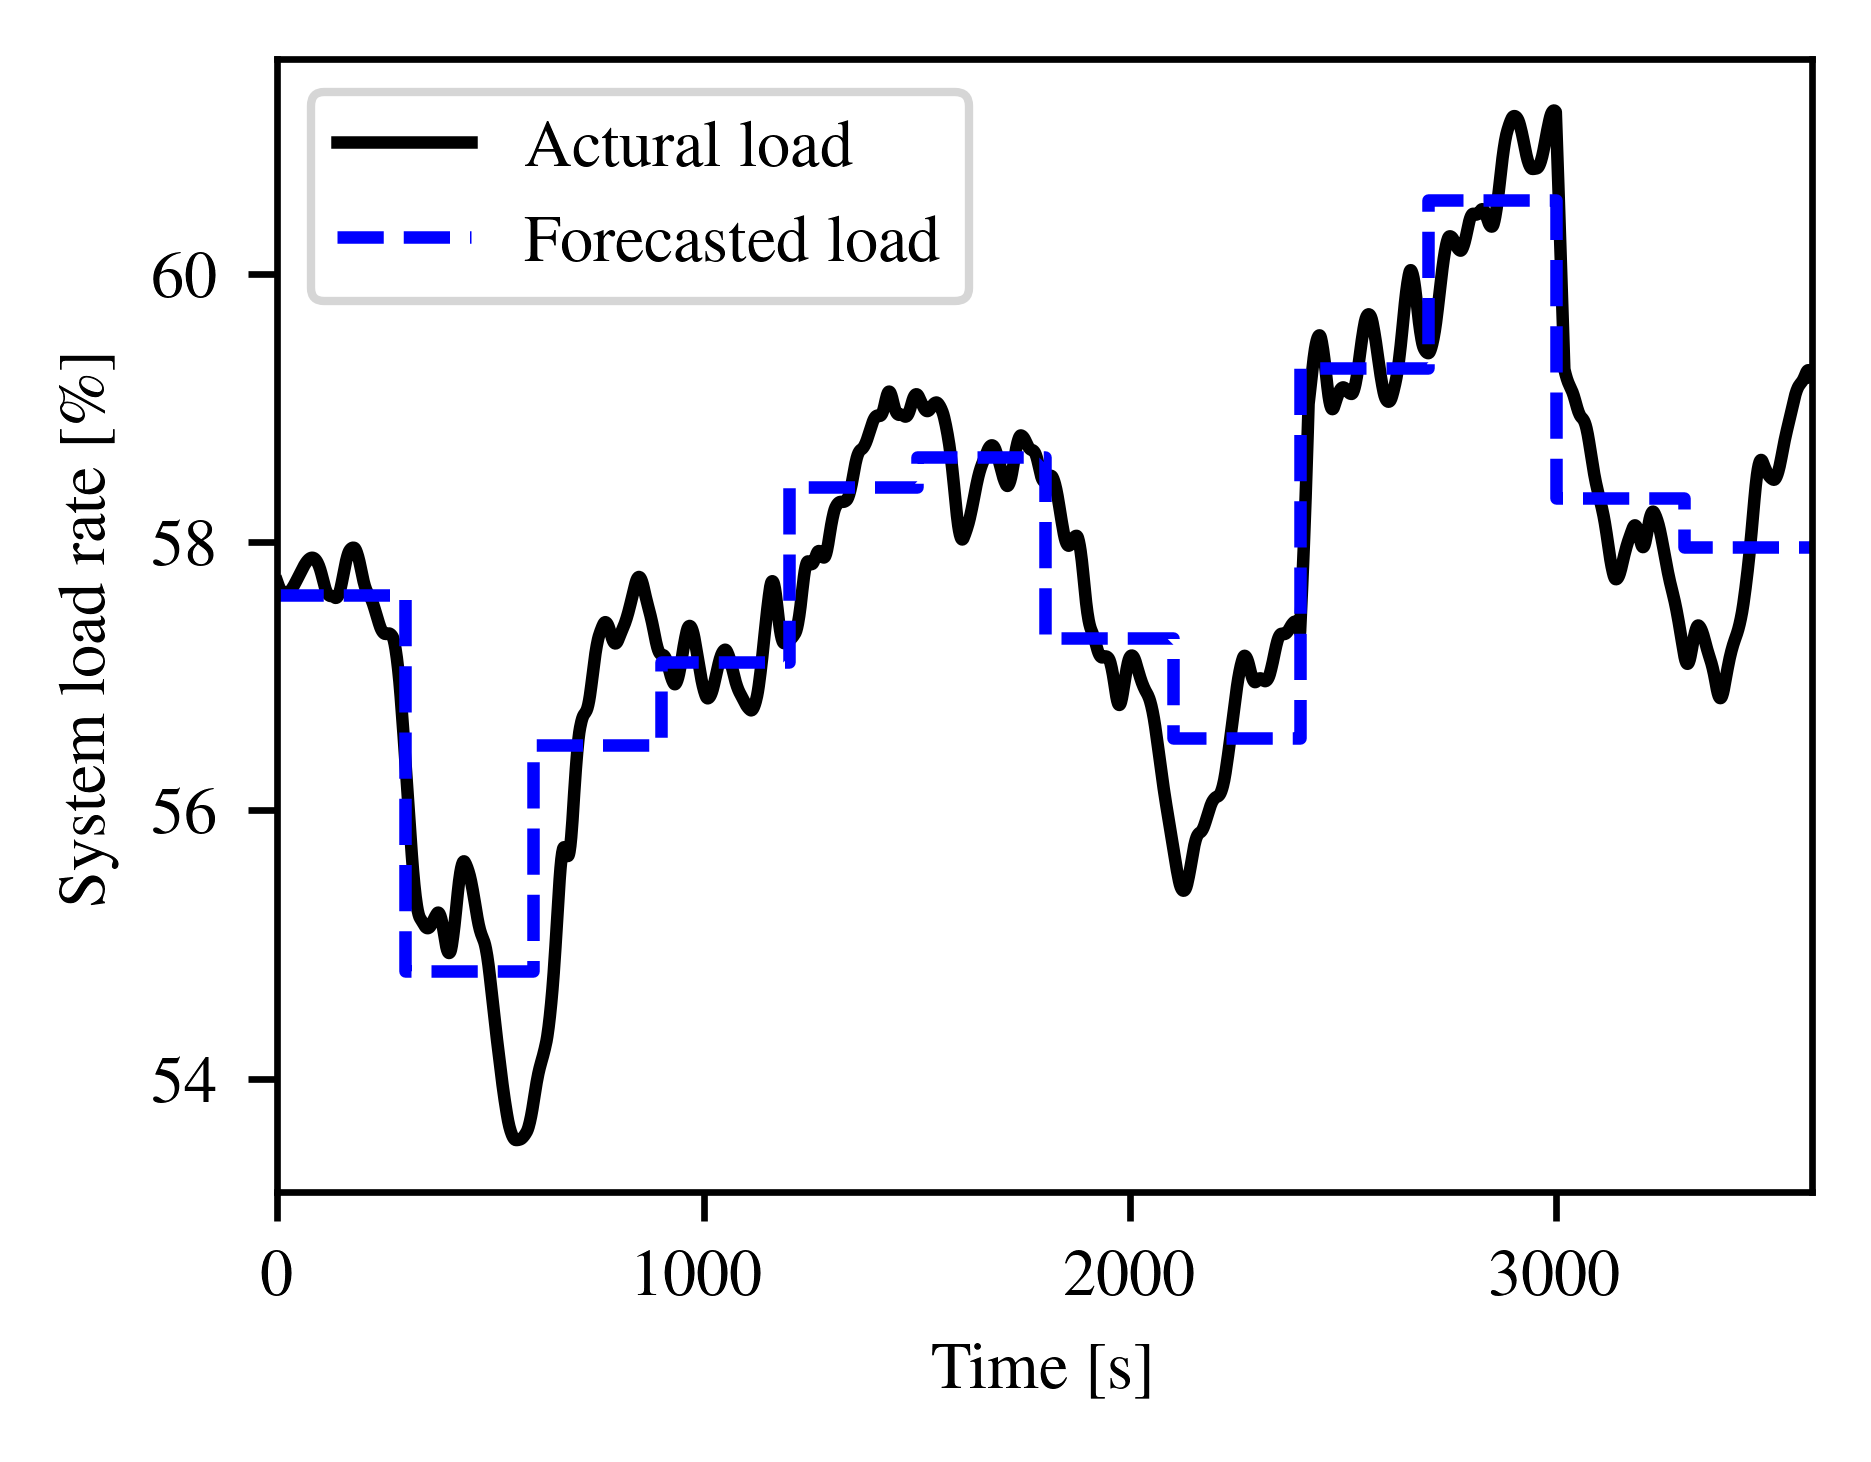

In [9]:
# plot load profile soterd in 'd_syn'
plt.style.use('ieee')
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots()
# tds load profile

ax.plot(
            d_syn['time'], 
            np.array(d_syn['sload']) * l_rate * 100,
            label = 'Actural load',
            linestyle='-'
        )

d_exp = d_syn.groupby(d_syn.index // 300).mean()
d_exp['time'] = range(0, 3600, 300)
ystep = list(d_exp['sload'])
ystep.insert(0, d_exp['sload'].iloc[0])

ax.step(
            range(0,3900,300), 
            np.array(ystep) * l_rate * 100,
            label = 'Forecasted load',
            color ='blue',
            linestyle='--'
        )

ax.set_xlabel('Time [s]')
ax.set_ylabel(r'System load rate [\%]')
ax.set_xlim(0, 3600, 600)
ax.legend()

## plot scheduling results

### plot cost
data
vis_res: dict
```
    vis_res[f'sg_{idx_ed}'] → dataframe
    vis_res[f'vsg_{idx_ed}'] → dataframe
    vis_res[f'MDsys_{idx_ed}'] → dict
    vis_res[f'dpe_{idx_ed}'] → int
```

sg dataframe: [gen Sn  pg  pru prd ] \
vsg dataframe: [gen  Mvsg  Dvsg pg_vsg  pru_vsg  prd_vsg  pmax_vsg  pmin_vsg] \
MDsys: {'Msys': ..., 'Dsys': ..., 'Rsys': ..., 'Fsys': ...}

In [10]:
# -----------------------Total Cost data ----------------------

base_cost = np.array(linearcost)
rs_cost = np.array([
                    20.11,
                    0,
                    0,
                    0,
                    0,
                    20.16,
                    0,
                    20.15,
                    20.16,
                    0
                ]) # vsg reserve cost

total_cost = []
delta_Pe = []
gen_cost = []
vsg_reserve_cost = []

for idx in range(12):
    # delta Pe
    delta_Pe.append(vis_res[f'dpe_{idx}'])
    # gen cost
    gen_cost.append(vis_res[f'cost_{idx}'])
    # vsg reserve cost
    up_reserve = vis_res[f'sg_{idx}']['pru'].values
    dn_reserve = vis_res[f'sg_{idx}']['prd'].values
    reserve = up_reserve + dn_reserve
    cost_reserve = np.inner(reserve, rs_cost)
    vsg_reserve_cost.append(cost_reserve)
    # total cost
    total_cost.append(gen_cost[idx] + cost_reserve)

# update the first interval
delta_Pe[0] = delta_Pe[1]/2
total_cost[0] += vsg_reserve_cost[0]
vsg_reserve_cost[0] = vsg_reserve_cost[1]/2

In [11]:
# -------------------- cost data for each gen ----------------------
# gen data and reserve data
sg_gen = pd.DataFrame()
pru_gen = pd.DataFrame()
prd_gen = pd.DataFrame()

for idx in range(12):
    sg_gen[f'{idx}'] = vis_res[f'sg_{idx}']['pg']
    pru_gen[f'{idx}'] = vis_res[f'sg_{idx}']['pru']
    prd_gen[f'{idx}'] = vis_res[f'sg_{idx}']['prd']

# gen cost and reserve cost
# TODO

complete_gen_cost = sg_gen.values.T * linearcost 

complete_rs_cost = pru_gen.values.T * rs_cost + prd_gen.values.T * rs_cost

complete_cost = complete_gen_cost + complete_rs_cost

temp = complete_cost.T
complete_cost.shape # (12, 10): (VIS interval, gen number)

(12, 10)

In [39]:
from matplotlib.pyplot import MultipleLocator

Text(12.5, 10.6, 'Cost [$\\times {10}^4$ \\$]')

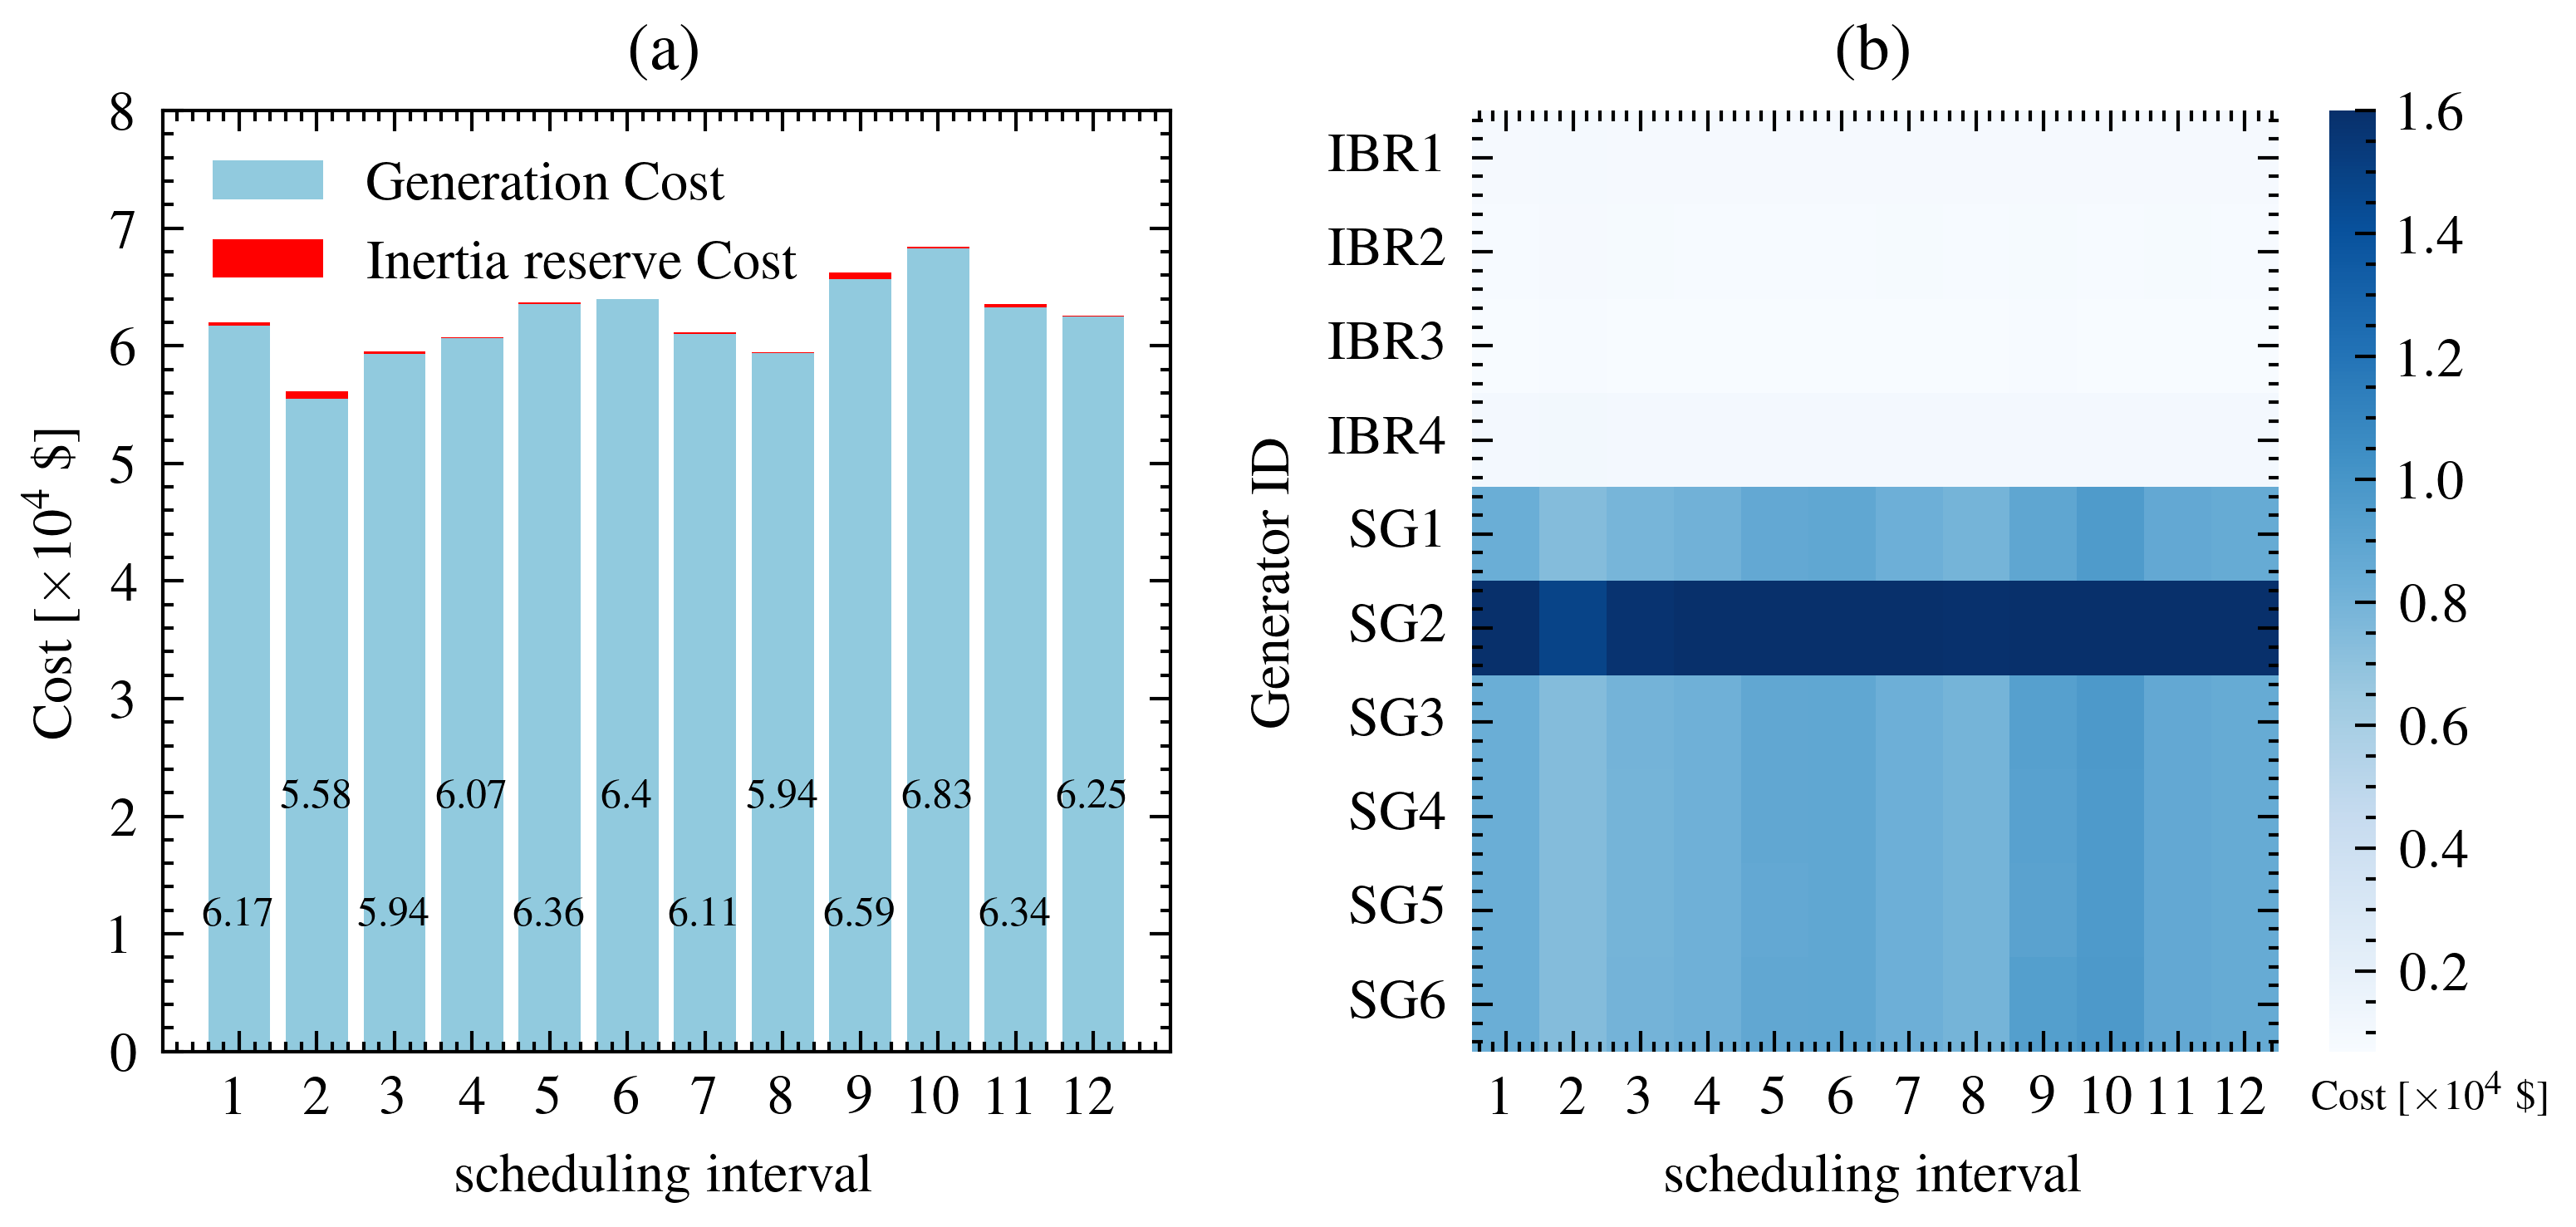

In [50]:
x = np.arange(1, 13, 1)

fig = plt.figure(figsize=(6, 2.5))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.3, hspace=0.6)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# ------------------   ax1: cost results ----------------------
ax1.bar(
            x, 
            np.array(gen_cost) / 100,
            color='#2596be',
            label='Generation Cost',
            alpha=0.5
        )
        
rects = ax1.patches
cost_bar = [round(i,2)/100 for i in total_cost]
labels = [f'{round(i,2)}' for i in cost_bar]
max_bar = max(cost_bar)
min_bar = min(cost_bar)

for rect, label, criteria, idx in zip(rects, labels, cost_bar, range(12)):

    height = rect.get_height()

    # ax1.text(
    #     rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom", size = 5
    # )

    # if criteria == max_bar:
    #     ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, 'max', ha="center", va="bottom", size = 6, color='k')
    #     ax1.text(rect.get_x() + rect.get_width() / 2, height + 1.5, label, ha="center", va="bottom", size = 6, color='k')
    # if criteria == min_bar:
    #     ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, 'min', ha="center", va="bottom", size = 6, color='black')
    #     ax1.text(rect.get_x() + rect.get_width() / 2, height + 1.5, label, ha="center", va="bottom", size = 6, color='black')

    if idx % 2 == 0:
        ax1.text(rect.get_x() + rect.get_width() / 2, 1, label, ha="center", va="bottom", size = 6, color='black')
    else:
        ax1.text(rect.get_x() + rect.get_width() / 2, 2, label, ha="center", va="bottom", size = 6, color='k')


ax1.bar(
            x,  
            np.array(vsg_reserve_cost)*2 / 100, 
            bottom=np.array(gen_cost)/100,
            color='red',
            label='Inertia reserve Cost',
        )
ax1.set_title('(a)')
# ax1.set_xlim(0, 13, 1)
ax1.set_ylim(0, 8)
ax1.set_xlabel('scheduling interval')
ax1.set_ylabel(r'Cost [$\times {10}^4$ \$]')
ax1.legend(loc='upper left')

# set x axis interval
x_interval = MultipleLocator(1)
ax1.xaxis.set_major_locator(x_interval)


# ------------------ ax2: cost of each gen ----------------------
# cost matrix (10, 12)
a = temp[[0, 5, 7, 8], :] # vsg 1,6,8,9
b = temp[[1, 2, 3, 4, 6, 9], :]
complete_cost = np.concatenate((a, b), axis=0)
# ysticks
ysticks = ['IBR1', 'IBR2', 'IBR3', 'IBR4', 
           'SG1', 'SG2', 'SG3', 'SG4', 'SG5', 'SG6']

ax2 = sns.heatmap(np.array(complete_cost)/100, yticklabels=ysticks, xticklabels=range(1,13,1), cmap='Blues')
ax2.set_title('(b)')
ax2.set_xlabel('scheduling interval')
ax2.set_ylabel(r'Generator ID')
ax2.text(12.5, 10.6, r'Cost [$\times {10}^4$ \$]', size = 6, color='k')

# # ax2: delta Pe
# ax2 = ax1.twinx()
# ax2.plot(
#             x, 
#             abs(np.array(delta_Pe)),
#             linestyle = '-',
#             color='black', 
#             label=r'$|\Delta P_e|$'
#         )

# ax2.set_xlabel='Virtual inertia scheduling interval' 
# ax2.set_ylabel(r'$|\Delta P_e|$ [p.u.]')
# ax2.set_ylim(-0, 0.1)
# ax2.legend(loc='upper right')

### plot M and D

In [13]:
# move the last num to the first one
def ad_list(a):
    a = [a[1]] + a
    return a

In [14]:
# ----------------------- dynamic scheduling data ----------------------

Msys, Dsys = [], []
Mvsg1, Dvsg1 = [], []
Mvsg2, Dvsg2 = [], []
Mvsg3, Dvsg3 = [], []
Mvsg4, Dvsg4 = [], []

for idx in range(12):
    # Msys, Dsys
    Msys.append(vis_res[f'MDsys_{idx}']['Msys'])
    Dsys.append(vis_res[f'MDsys_{idx}']['Dsys'])
    # Mvsg1, Dvsg1
    Mvsg1.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[0])
    Dvsg1.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[0])
    # Mvsg2, Dvsg2
    Mvsg2.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[1])
    Dvsg2.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[1])
    # Mvsg3, Dvsg3
    Mvsg3.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[2])
    Dvsg3.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[2])
    # Mvsg4, Dvsg4
    Mvsg4.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[3])
    Dvsg4.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[3])

Msys = ad_list(Msys)
Mvsg1 = ad_list(Mvsg1)
Mvsg2 = ad_list(Mvsg2)
Mvsg3 = ad_list(Mvsg3)
Mvsg4 = ad_list(Mvsg4)

Dsys = ad_list(Dsys)
Dvsg1 = ad_list(Dvsg1)
Dvsg2 = ad_list(Dvsg2)
Dvsg3 = ad_list(Dvsg3)
Dvsg4 = ad_list(Dvsg4)

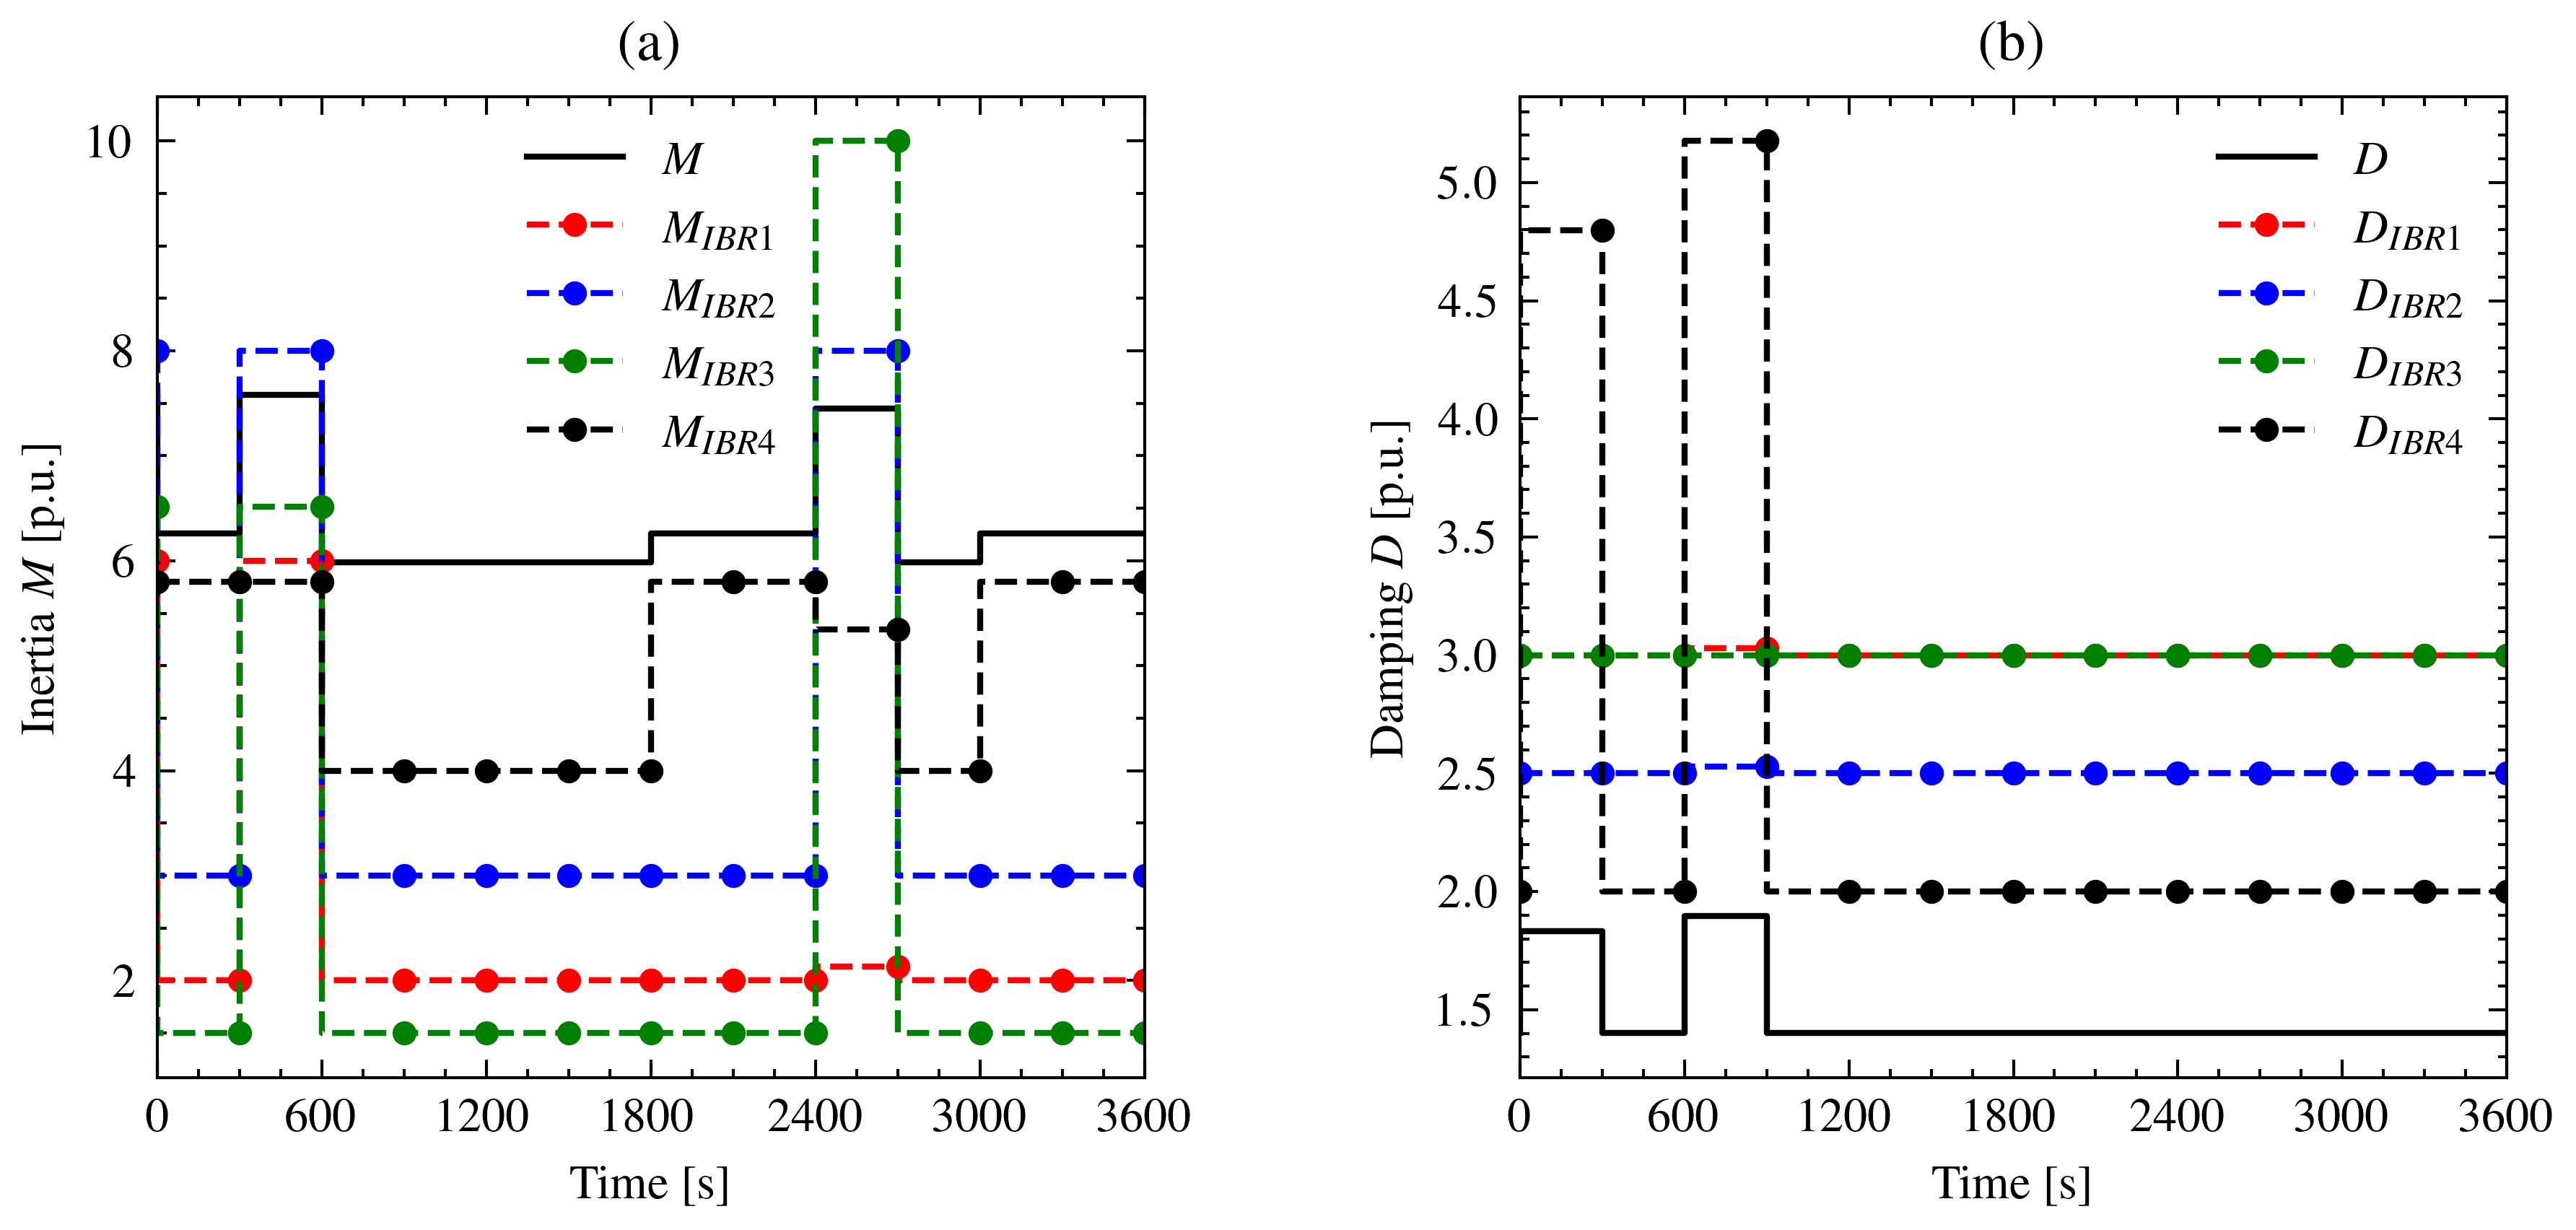

In [45]:
fig = plt.figure(figsize=(7, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.38, hspace=0.6)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.step(range(0,3900,300), Msys, '-', label=r'$M$')
ax1.step(range(0,3900,300), Mvsg1, '--.', label=r'$M_{IBR1}$')
ax1.step(range(0,3900,300), Mvsg2, '--.', label=r'$M_{IBR2}$')
ax1.step(range(0,3900,300), Mvsg3, '--.', label=r'$M_{IBR3}$')
ax1.step(range(0,3900,300), Mvsg4, '--.', label=r'$M_{IBR4}$')

ax1.set_xlim(0,3600)
ax1.set_title('(a)')
ax1.set_ylabel(r'Inertia $M$ [p.u.]')
ax1.set_xlabel('Time [s]')
ax1.legend()
# set x axis interval
x_interval = MultipleLocator(600)
ax1.xaxis.set_major_locator(x_interval)

ax2.step(range(0,3900,300), Dsys, '-', label=r'$D$')
ax2.step(range(0,3900,300), Dvsg1, '--.', label=r'$D_{IBR1}$')
ax2.step(range(0,3900,300), Dvsg2, '--.', label=r'$D_{IBR2}$')
ax2.step(range(0,3900,300), Dvsg3, '--.', label=r'$D_{IBR3}$')
ax2.step(range(0,3900,300), Dvsg4, '--.', label=r'$D_{IBR4}$')

ax2.set_xlim(0, 3600)
ax2.set_title('(b)')
ax2.set_ylabel(r'Damping $D$ [p.u.]')
ax2.set_xlabel('Time [s]')
ax2.legend()
# set x axis interval
x_interval = MultipleLocator(600)
ax2.xaxis.set_major_locator(x_interval)


### plot $\Delta P_e$ and VSG reserved capacity

In [26]:
# get data
delta_Pe

total_rs = []
vsg1_rs = []
vsg2_rs = []
vsg3_rs = []
vsg4_rs = []

for idx in range(12):
    # total reserve
    vsg_rsu = vis_res[f'vsg_{idx}']['pru_vsg'].values * 15
    vsg_rsd = vis_res[f'vsg_{idx}']['prd_vsg'].values * 15
    vsg_rs = vsg_rsu - vsg_rsd
    total_rs.append(vsg_rs.sum())
    
    # vsg1 reserve
    vsg1_rs.append(vsg_rsu[0] - vsg_rsd[0])
    # vsg2 reserve
    vsg2_rs.append(vsg_rsu[1] - vsg_rsd[1])
    # vsg3 reserve
    vsg3_rs.append(vsg_rsu[2] - vsg_rsd[2])
    # vsg4 reserve
    vsg4_rs.append(vsg_rsu[3] - vsg_rsd[3])


In [17]:

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

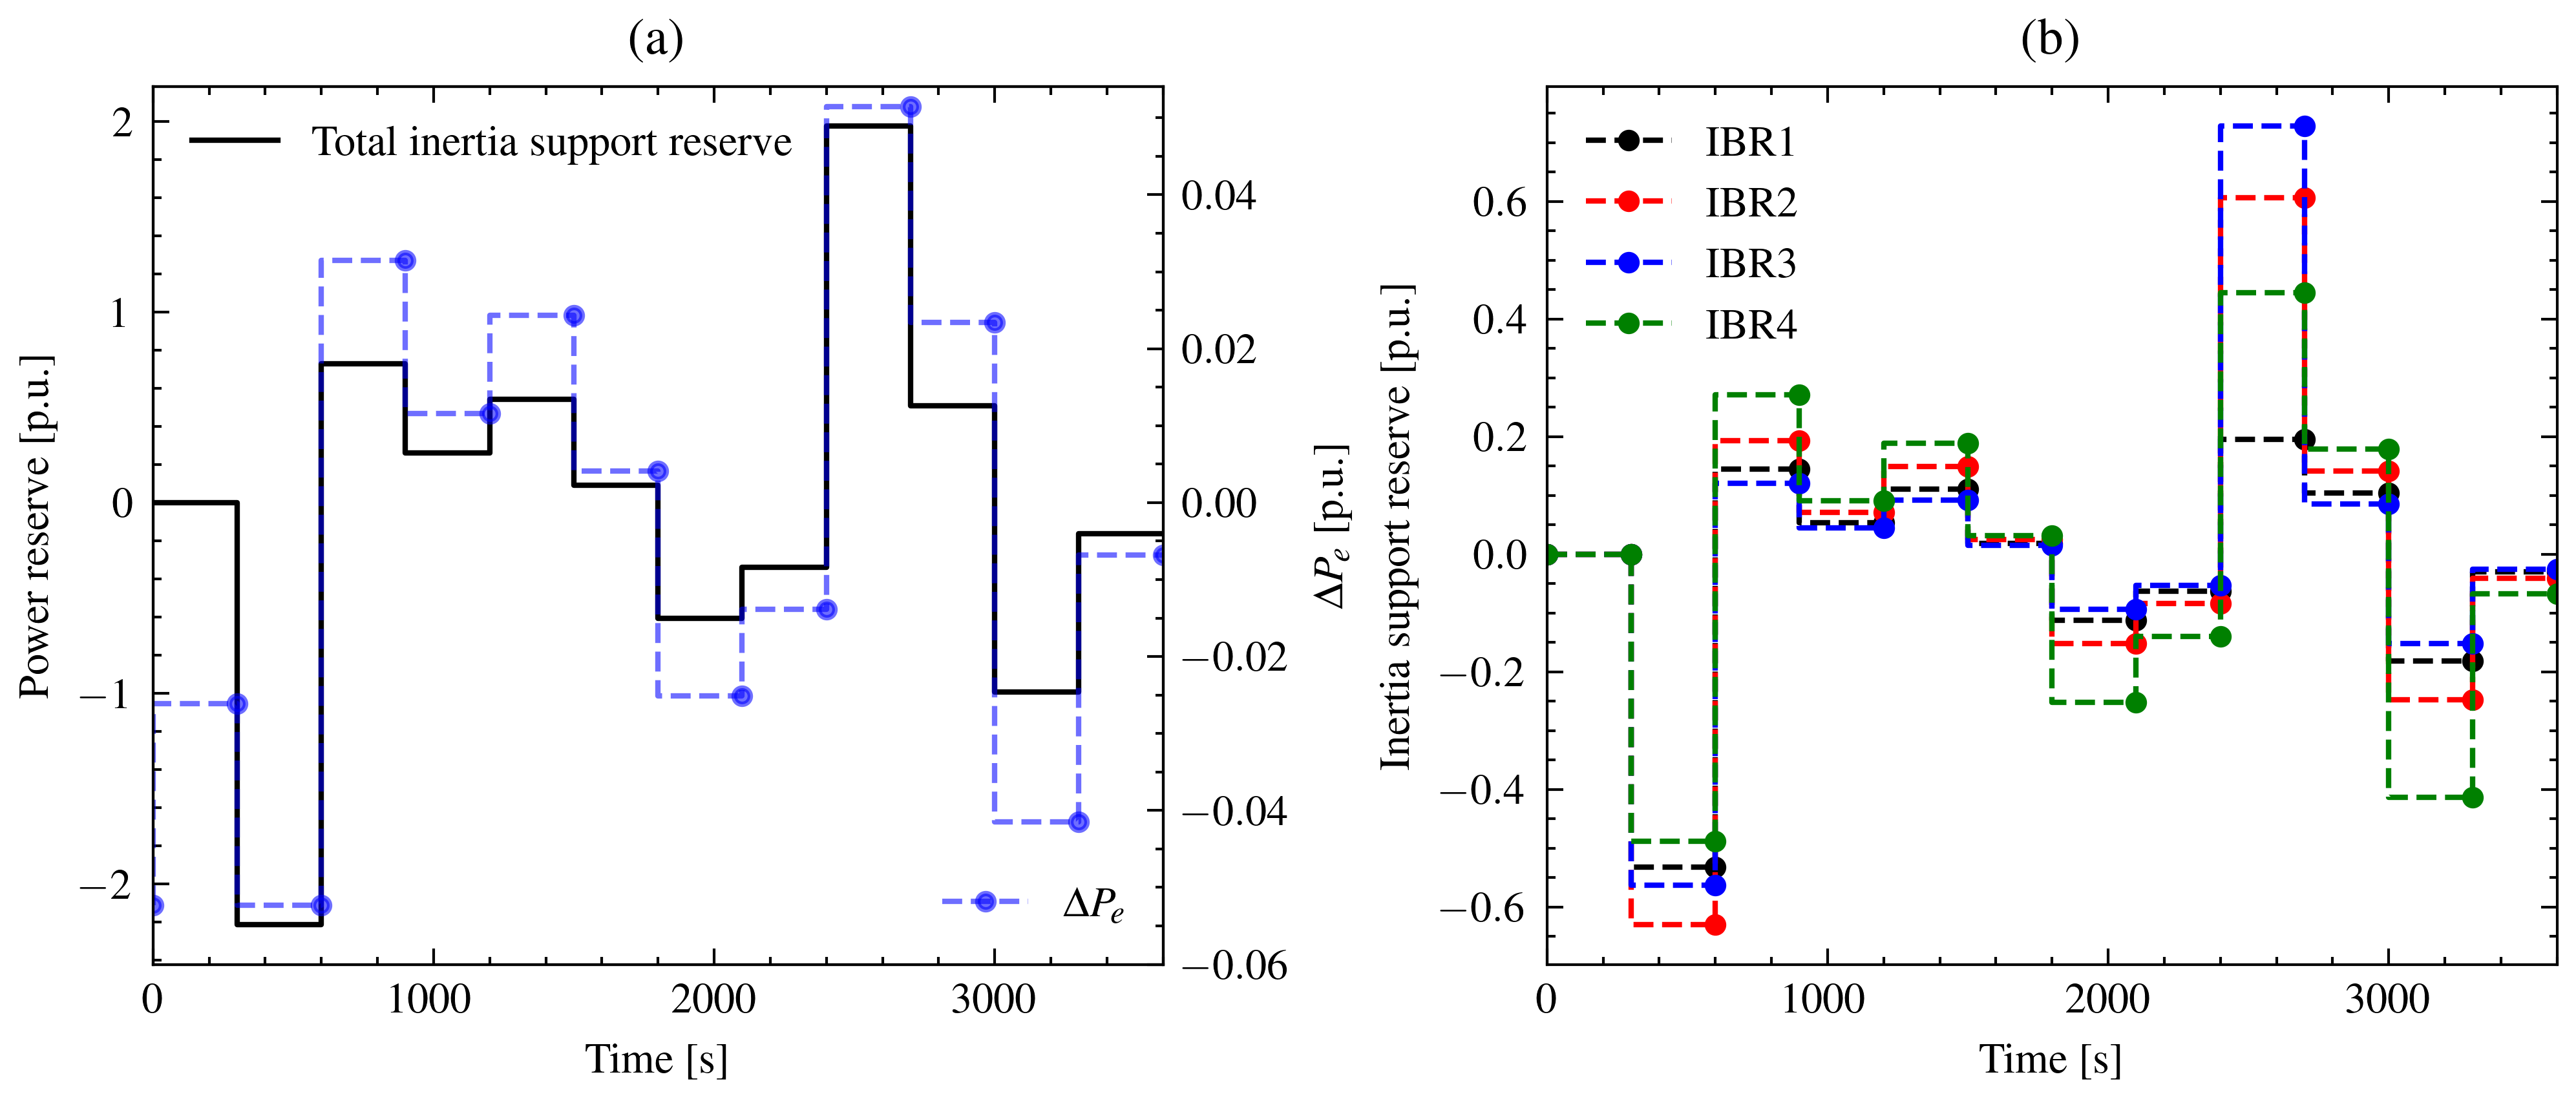

In [34]:
fig = plt.figure(figsize=(8, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.38, hspace=0.6)
ax1 = fig.add_subplot(121) # total reserve
ax2 = fig.add_subplot(122)

ax1_twin = ax1.twinx() # delta Pe

# ----------------------- total reserve ----------------------
ax1.step(range(0,3900,300), [total_rs[0]] + total_rs, '-', label='Total inertia support reserve')
ax1.set_ylabel('Power reserve [p.u.]')
ax1.set_xlabel('Time [s]')
ax1.legend(loc='upper left')
ax1.set_xlim(0, 3600, 300)
ax1.set_title('(a)')

# ax1_twin.step(range(0,3900,300), [delta_Pe[0]] + delta_Pe, '--.', color='blue', label=r'$\Delta P_e$', alpha=0.57)
ax1_twin.step(range(0,3900,300), delta_Pe, '--.', color='blue', label=r'$\Delta P_e$', alpha=0.57)
ax1_twin.set_ylabel(r'$\Delta P_e$ [p.u.]')
ax1_twin.legend(loc='lower right')
ax1_twin.set_xlim(0,3600,300)
align_yaxis(ax1, 0, ax1_twin, 0)

# ----------------------- VSG pwoer reserve ----------------------
ax2.step(range(0,3900,300), [vsg1_rs[0]] + vsg1_rs, '--.', label='IBR1')
ax2.step(range(0,3900,300), [vsg2_rs[0]] + vsg2_rs, '--.', label='IBR2')
ax2.step(range(0,3900,300), [vsg3_rs[0]] + vsg3_rs, '--.', label='IBR3')
ax2.step(range(0,3900,300), [vsg4_rs[0]] + vsg4_rs, '--.', label='IBR4')

ax2.set_xlim(0, 3600, 300)
ax2.set_title('(b)')
ax2.set_ylabel('Inertia support reserve [p.u.]')
ax2.set_xlabel('Time [s]')
ax2.legend()


## plot TDS results

(<Figure size 9600x4800 with 8 Axes>,
 <AxesSubplot:title={'center':'h'}, xlabel='Time [s]', ylabel='Pe [p.u.]'>)

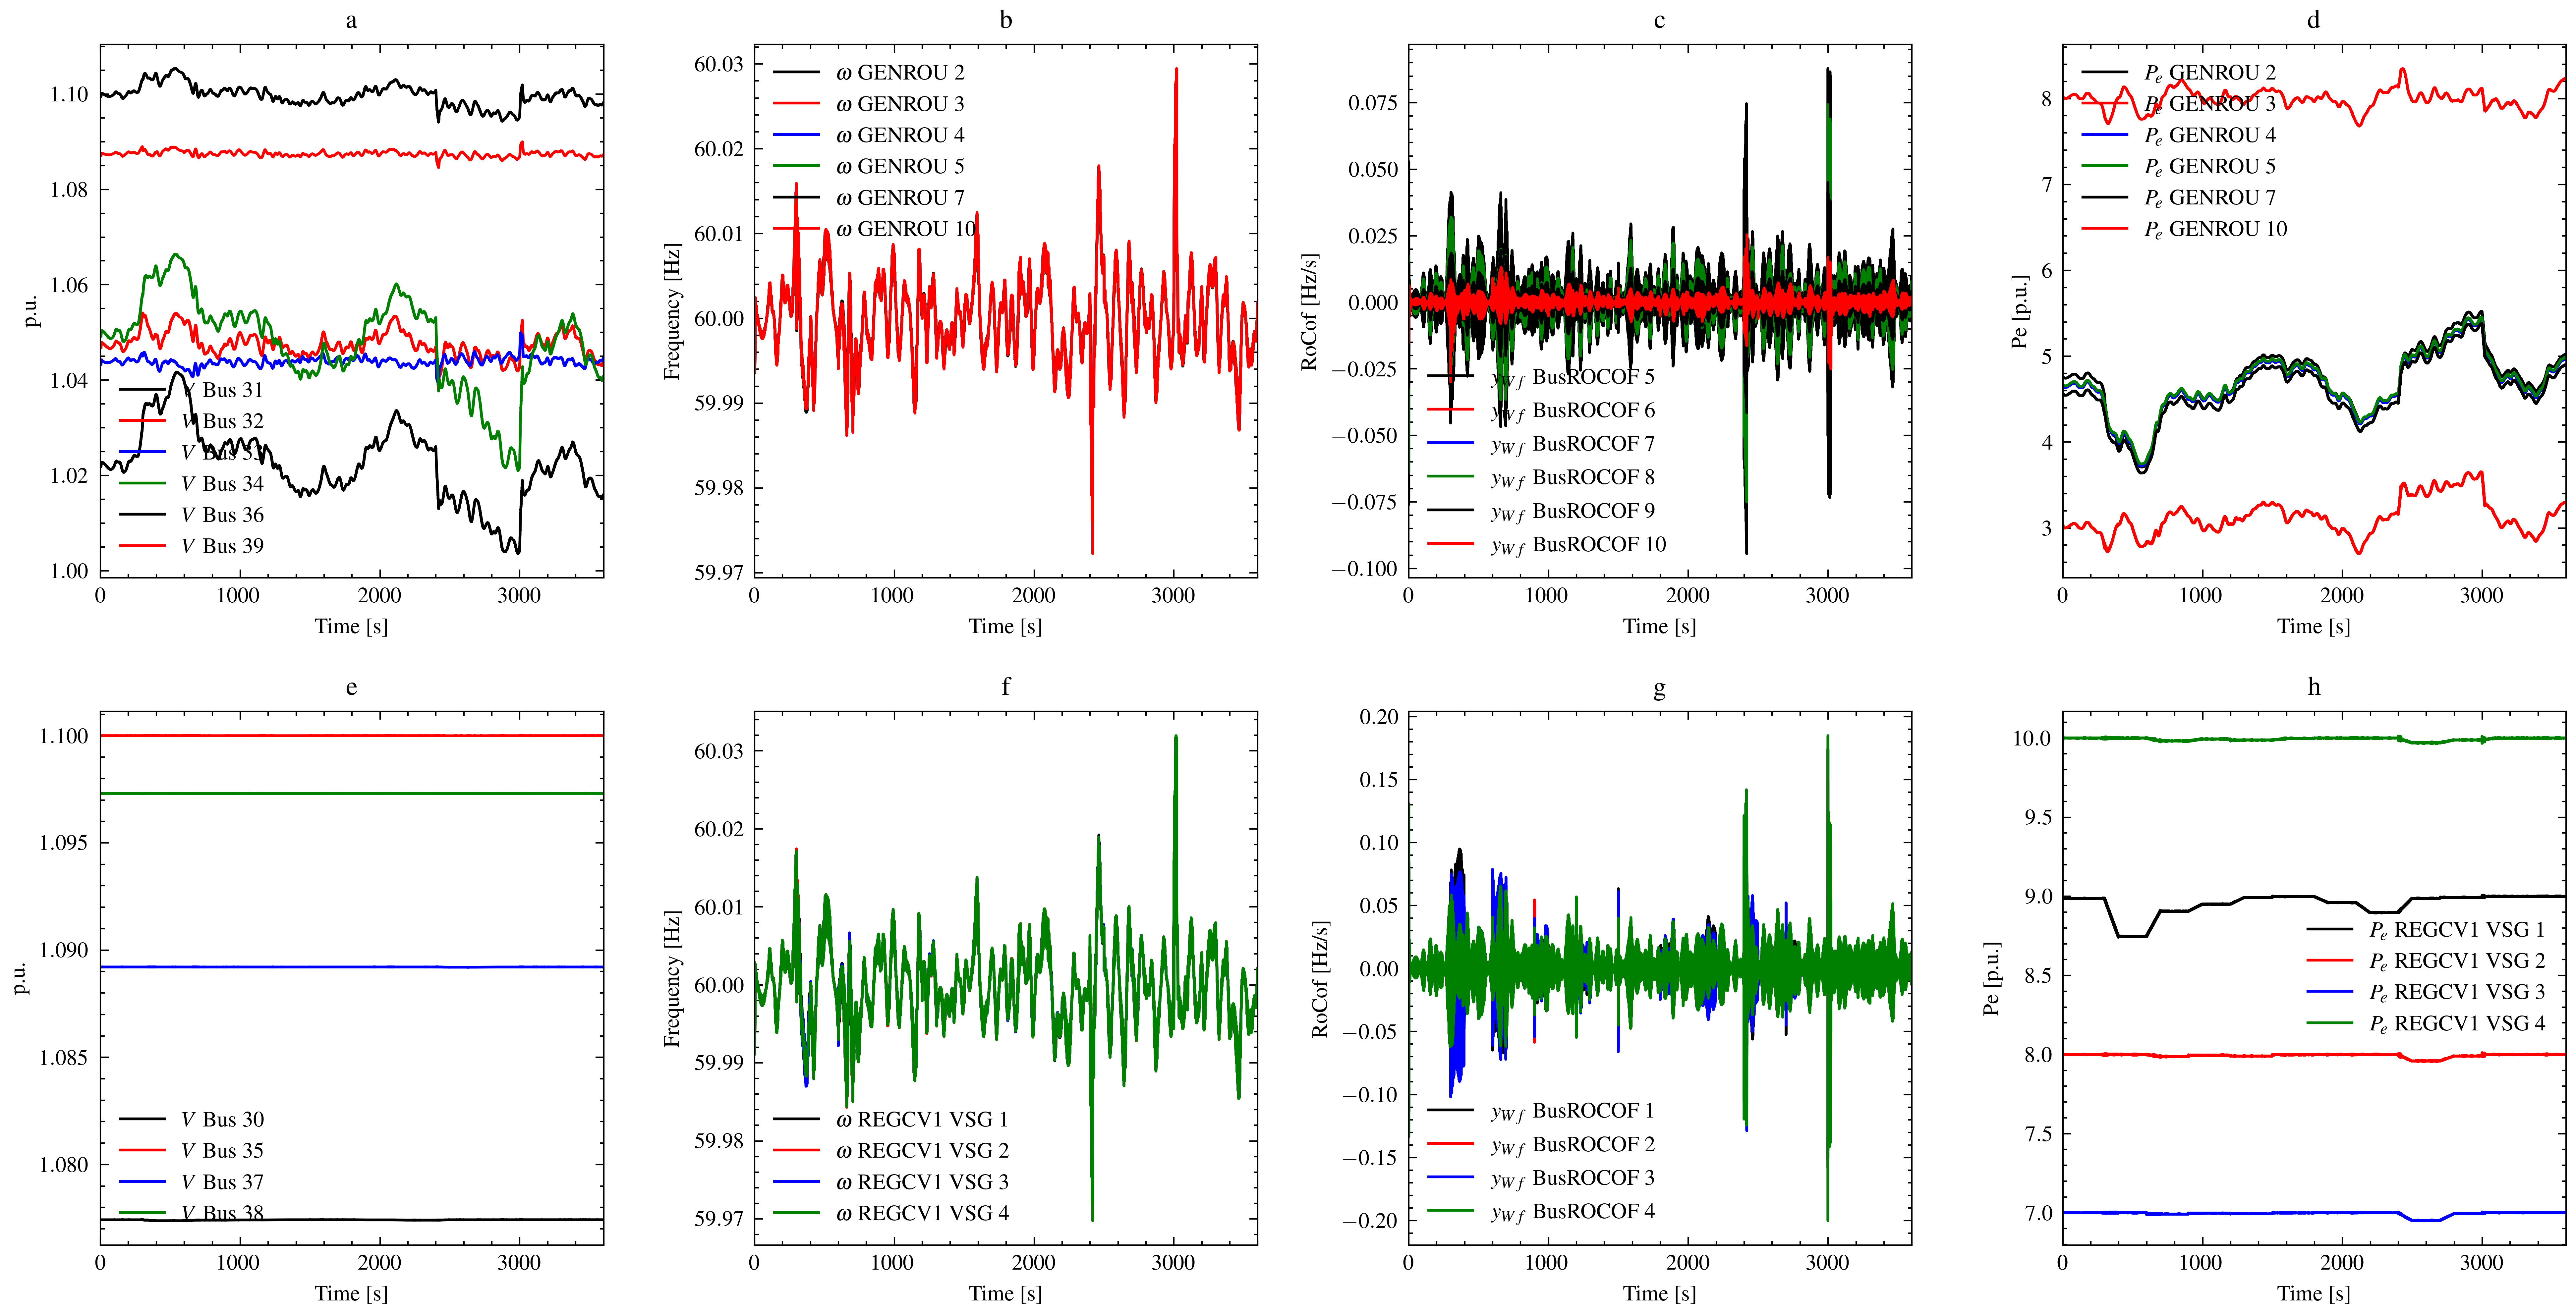

In [51]:
fig_gen, ax_gen = plt.subplots(2, 4, figsize=(16, 8))

plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.3, hspace=0.25)

IBR_legend = ['IBR1','IBR2','IBR3','IBR4']
SG_legend = ['SG1', 'SG2', 'SG3','SG4','SG5','SG6',]

# voltage

ssa.TDS.plt.plot(
                    ssa.GENROU.v,
                    linestyles=['-'], style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'a',
                    ylabel='p.u.',
                    fig=fig_gen, 
                    ax=ax_gen[0, 0]
                )

ssa.TDS.plt.plot(
                    ssa.REGCV1.v,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'e',
                    ylabel='p.u.',
                    fig=fig_gen, 
                    ax=ax_gen[1, 0]
                )

# frequency
ssa.TDS.plt.plot(
                    ssa.GENROU.omega,
                    ytimes=60,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'b',
                    ylabel='Frequency [Hz]',
                    fig=fig_gen, 
                    ax=ax_gen[0, 1],
                )

ssa.TDS.plt.plot(
                    ssa.REGCV1.omega,
                    ytimes=60,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'f',
                    ylabel='Frequency [Hz]',
                    fig=fig_gen, 
                    ax=ax_gen[1, 1],
                )

# rocof
ssa.TDS.plt.plot(
                    ssa.BusROCOF.Wf_y,
                    a =(4,5,6,7,8,9),
                    ytimes=60,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'c',
                    ylabel='RoCof [Hz/s]',
                    fig=fig_gen, 
                    ax=ax_gen[0, 2]
                )

ssa.TDS.plt.plot(
                    ssa.BusROCOF.Wf_y,
                    a =(0,1,2,3),
                    ytimes=60,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'g',
                    ylabel='RoCof [Hz/s]',
                    fig=fig_gen, 
                    ax=ax_gen[1, 2]
                )

# Pe
ssa.TDS.plt.plot(
                    ssa.GENROU.Pe,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'd',
                    ylabel='Pe [p.u.]',
                    fig=fig_gen, 
                    ax=ax_gen[0, 3]
                )

ssa.TDS.plt.plot(
                    ssa.REGCV1.Pe,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'h',
                    ylabel='Pe [p.u.]',
                    fig=fig_gen, 
                    ax=ax_gen[1, 3]
                )


andes plot ref:

https://docs.andes.app/en/latest/_modules/andes/plot.html#tdsplot

can search hline

1) save data and replot

https://docs.andes.app/en/latest/_examples/ex2.html#extracting-variable-data


In [3]:
t = ssa.dae.ts.t

v_sg = ssa.dae.ts.y[:, ssa.GENROU.v.a]
v_ibr = ssa.dae.ts.y[:, ssa.REGCV1.v.a]

omega_sg = ssa.dae.ts.x[:, ssa.GENROU.omega.a]
omega_ibr = ssa.dae.ts.y[:, ssa.REGCV1.omega.a]

rocof = ssa.dae.ts.y[:, ssa.BusROCOF.Wf_y.a]
rocof_sg = rocof[:,[4,5,6,7,8]]
rocof_ibr = rocof[:,[0,1,2,3,4]]

pe_sg = ssa.dae.ts.y[:, ssa.GENROU.Pe.a]
pe_ibr = ssa.dae.ts.y[:, ssa.REGCV1.Pe.a]

NameError: name 'ssa' is not defined

In [ ]:
fig_gen, ax_gen = plt.subplots(2, 4, figsize=(16, 8))

plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.3, hspace=0.25)

ibr_legend = ['IBR1','IBR2','IBR3','IBR4']
sg_legend = ['SG1', 'SG2', 'SG3','SG4','SG5','SG6',]

# ---- sg voltage ----
ax_gen[0, 0].plot(
                    t,
                    v_sg,
                )
ax_gen[0, 0].set_title('(a)')
ax_gen[0, 0].set_xlabel('Time [s]')
ax_gen[0, 0].set_ylabel('Voltage [p.u.]')
ax_gen[0, 0].legend(sg_legend)
ax_gen[0, 0].set_ylim([0.95, 1.12])
ax_gen[0, 0].set_xlim([0, 3600])

# ---- sg frequency ----
ax_gen[0, 1].plot(
                    t,
                    omega_sg * 60,
                    ':'
                )
ax_gen[0, 1].set_title('(b)')
ax_gen[0, 1].set_xlabel('Time [s]')
ax_gen[0, 1].set_ylabel('Frequency [p.u.]')
ax_gen[0, 1].legend(sg_legend)
ax_gen[0, 1].set_ylim([59.88, 60.12])
ax_gen[0, 1].set_xlim([0, 3600])

ax_gen[0, 1].plot(t, 60.1 * np.ones(t.shape), '--', color='k')
ax_gen[0, 1].plot(t, 59.9 * np.ones(t.shape), '--', color='k')
ax_gen[0, 1].text(0.75, 0.87,'upper limit', color='k', transform=ax_gen[0,1].transAxes)
ax_gen[0, 1].text(0.75, 0.1,'lower limit', color='k', transform=ax_gen[0,1].transAxes)


# ---- sg rocof ----
ax_gen[0, 2].plot(
                    t,
                    rocof_sg * 60,
                )
ax_gen[0, 2].set_title('(c)')
ax_gen[0, 2].set_xlabel('Time [s]')
ax_gen[0, 2].set_ylabel('RoCof [Hz/s]')
ax_gen[0, 2].legend(sg_legend)
ax_gen[0, 2].set_ylim([-0.99, 1.01])
ax_gen[0, 2].set_xlim([0, 3600])
ax_gen[0, 2].plot(t, 1 * np.ones(t.shape), '--', color='k')
ax_gen[0, 2].plot(t, -1 * np.ones(t.shape), '--', color='k')
ax_gen[0, 2].text(0.75, 0.87,'upper limit', color='k', transform=ax_gen[0,2].transAxes)
ax_gen[0, 2].text(0.75, 0.1,'lower limit', color='k', transform=ax_gen[0,2].transAxes)


# ---- sg pe ----
ax_gen[0, 3].plot(
                    t,
                    pe_sg,
                )
ax_gen[0, 3].set_title('(d)')
ax_gen[0, 3].set_xlabel('Time [s]')
ax_gen[0, 3].set_ylabel('Pe [p.u.]')
ax_gen[0, 3].legend(sg_legend)
ax_gen[0, 3].set_xlim([0, 3600])


# ---- ibr voltage ----
ax_gen[1, 0].plot(
                    t,
                    v_ibr,
                )
ax_gen[1, 0].set_title('(e)')
ax_gen[1, 0].set_xlabel('Time [s]')
ax_gen[1, 0].set_ylabel('Voltage [p.u.]')
ax_gen[1, 0].legend(ibr_legend)
ax_gen[1, 0].set_ylim([0.95, 1.12])
ax_gen[1, 0].set_xlim([0, 3600])


# ---- ibr frequency ----
ax_gen[1, 1].plot(
                    t,
                    omega_ibr * 60,
                    ':'
                )
ax_gen[1, 1].set_title('(f)')
ax_gen[1, 1].set_xlabel('Time [s]')
ax_gen[1, 1].set_ylabel('Frequency [p.u.]')
ax_gen[1, 1].legend(sg_legend)
ax_gen[1, 1].set_ylim([59.88, 60.12])
ax_gen[1, 1].set_xlim([0, 3600])
ax_gen[1, 1].plot(t, 60.1 * np.ones(t.shape), '--', color='k')
ax_gen[1, 1].plot(t, 59.9 * np.ones(t.shape), '--', color='k')
ax_gen[1, 1].text(0.75, 0.87,'upper limit', color='k', transform=ax_gen[0,1].transAxes)
ax_gen[1, 1].text(0.75, 0.1,'lower limit', color='k', transform=ax_gen[0,1].transAxes)


# ---- ibr rocof ----
ax_gen[1, 2].plot(
                    t,
                    rocof_ibr * 60,
                )
ax_gen[1, 2].set_title('(g)')
ax_gen[1, 2].set_xlabel('Time [s]')
ax_gen[1, 2].set_ylabel('RoCof [Hz/s]')
ax_gen[1, 2].legend(sg_legend)
ax_gen[1, 2].set_ylim([-0.99, 1.01])
ax_gen[1, 2].set_xlim([0, 3600])
ax_gen[1, 2].plot(t, 1 * np.ones(t.shape), '--', color='k')
ax_gen[1, 2].plot(t, -1 * np.ones(t.shape), '--', color='k')
ax_gen[1, 2].text(0.75, 0.87,'upper limit', color='k', transform=ax_gen[0,2].transAxes)
ax_gen[1, 2].text(0.75, 0.1,'lower limit', color='k', transform=ax_gen[0,2].transAxes)


# ---- ibr pe ----
ax_gen[1, 3].plot(
                    t,
                    pe_ibr,
                )
ax_gen[1, 3].set_title('(h)')
ax_gen[1, 3].set_xlabel('Time [s]')
ax_gen[1, 3].set_ylabel('Pe [p.u.]')
ax_gen[1, 3].legend(sg_legend)
ax_gen[1, 3].set_xlim([0, 3600])

NameError: name 'plt' is not defined